# Meta Labeling

In [409]:
import pandas as pd
import numpy as np

In [410]:
df = pd.read_csv('btc_dataset_volume_1_hour.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='mixed', utc=True)
df = df.set_index('date_time')
df = df[~df.index.duplicated(keep='first')]
df = df[df.index<'2024']
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2017-08-18 05:38:13.281000+00:00,4930,4261.48,4485.39,4134.61,4289.33,1162.561720,507.803426,4930,5.020619e+06
2017-08-19 13:37:23.529000+00:00,10429,4289.33,4371.52,3850.00,4095.75,1162.142969,504.155615,5499,4.861709e+06
2017-08-21 21:26:36.311000+00:00,16795,4095.75,4211.08,3911.79,4012.00,1162.019144,542.431195,6366,4.741410e+06
2017-08-23 03:42:00.239000+00:00,24537,4012.00,4127.99,3400.00,4106.65,1162.060881,615.735042,7742,4.546521e+06
2017-08-24 09:45:24.276000+00:00,34411,4124.36,4265.80,4035.32,4210.00,1162.034871,606.934588,9874,4.827208e+06


## 1. Primary Model

In [411]:
bb_window = 30
bb_k = 2

df['bb_upper'] = df['close'].rolling(window=bb_window).mean() + bb_k * df['close'].rolling(window=bb_window).std(ddof=0)
df['bb_lower'] = df['close'].rolling(window=bb_window).mean() - bb_k * df['close'].rolling(window=bb_window).std(ddof=0)

df.dropna(inplace=True)


long_events = df[
    (df['close'] < df['bb_lower']) &
    (df['close'].shift(1) >= df['bb_lower'].shift(1))
].index


In [412]:
from mlfinpy.util.frac_diff import frac_diff_ffd, plot_min_ffd

frac_diff_series_close = frac_diff_ffd(df[['close']], 0.4)
frac_diff_series_open = frac_diff_ffd(df[['open']], 0.4)
frac_diff_series_low = frac_diff_ffd(df[['low']], 0.4)
frac_diff_series_high = frac_diff_ffd(df[['high']], 0.4)

In [413]:
df['frac_close'] = frac_diff_series_close
df['frac_open'] = frac_diff_series_open
df['frac_low'] = frac_diff_series_low
df['frac_high'] = frac_diff_series_high

In [414]:
from mlfinpy.labeling.labeling import get_events, drop_labels
from mlfinpy.util import get_daily_vol
from mlfinpy.labeling import get_events
from mlfinpy.labeling.labeling import add_vertical_barrier

pt_sl = [1,1]
min_ret = 0.005

# Creates the vertical barriers
verticle_barriers = add_vertical_barrier(long_events, df['close'],num_days=5)
verticle_barriers.head()


# Daily volatility
daily_vol = get_daily_vol(close=df['close'], lookback=150)

# Creates the side (Long)
side = pd.Series(1, index=long_events) 

# Get triple barriers events
triple_barrier_events = get_events(close=df['close'],
                                               t_events=long_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=verticle_barriers,
                                               side_prediction=side)


from mlfinpy.labeling import get_bins
meta_labels = get_bins(triple_barrier_events, df['close'])
clean_meta_labels = drop_labels(meta_labels, min_pct=0.1)
clean_meta_labels.bin.value_counts()


events = pd.concat([df, clean_meta_labels], axis=1).dropna()
events = events.sort_index()

2026-02-12 21:23:07.913873 100.0% triple_barriers done after 0.03 minutes. Remaining 0.0 minutes..


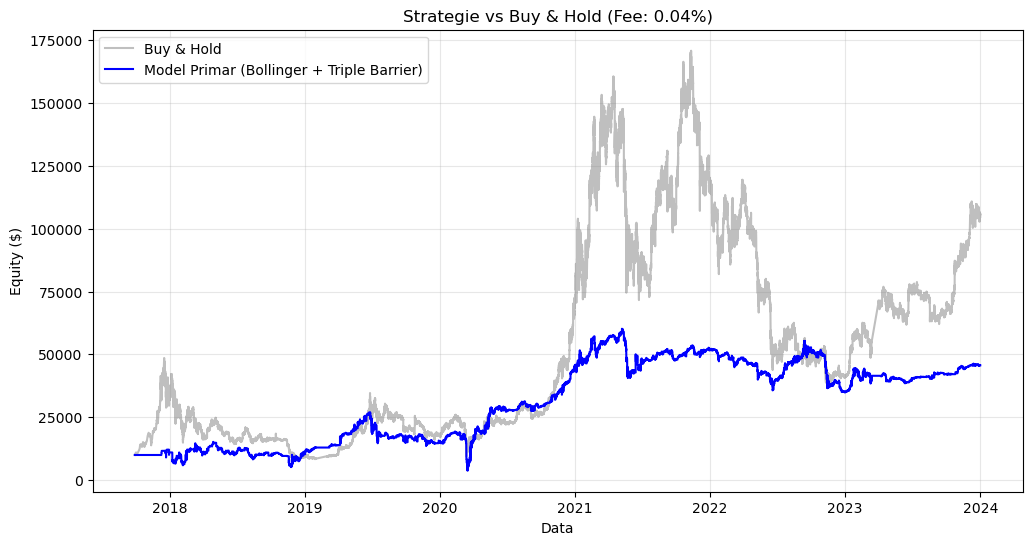

Randament Model: 356.62% | Tranzacții: 3920
Randament B&H:   946.61%


In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_primary_model(df, signals, volatility_series, 
                           pt_sl=[1, 2], barrier_days=5, 
                           fee=0.001, initial_capital=10000, investment_amount=None):
    """
    Simulează execuția strategiei (Modelul Primar).
    
    Parametri:
    - df: DataFrame cu prețurile (index datetime, coloana 'close').
    - signals: Index-ul cu datele de intrare (long_events).
    - volatility_series: Seria cu volatilitatea (daily_vol).
    - pt_sl: [TP multiplier, SL multiplier] (ex: [1, 2]).
    - fee: Comision per tranzacție (ex: 0.001 = 0.1%).
    - initial_capital: Suma de start.
    - investment_amount: 
        * None -> Compounding (Investește tot capitalul disponibil).
        * Număr (ex: 100) -> Investește sumă fixă per tranzacție.
    """
    
    capital = initial_capital
    equity_curve = pd.Series(index=df.index, data=np.nan)
    equity_curve.iloc[0] = initial_capital
    
    trades = []
    
    # Variabilă pentru a urmări când suntem liberi să intrăm (pentru modul Compounding)
    next_available_time = df.index[0]
    
    # Sortăm semnalele cronologic
    valid_signals = sorted([t for t in signals if t in df.index])
    
    current_balance = initial_capital

    for entry_time in valid_signals:
        # 1. Mod Compounding: Dacă suntem deja într-un trade, ignorăm semnalul
        if investment_amount is None and entry_time < next_available_time:
            continue
            
        entry_price = df.loc[entry_time, 'close']
        vol = volatility_series.loc[entry_time] if entry_time in volatility_series.index else volatility_series.iloc[-1]
        
        # 2. Setare Bariere (Triple Barrier)
        # TP = Entry * (1 + profit_mult * vol)
        # SL = Entry * (1 - loss_mult * vol)
        profit_target = entry_price * (1 + pt_sl[0] * vol)
        stop_loss = entry_price * (1 - pt_sl[1] * vol)
        time_limit = entry_time + pd.Timedelta(days=barrier_days)
        
        # 3. Determinare Ieșire
        # Luăm datele viitoare până la limita de timp
        future_data = df.loc[entry_time:time_limit].iloc[1:] # excludem bara de intrare
        
        if future_data.empty:
            continue
            
        exit_time = time_limit
        exit_price = future_data['close'].iloc[-1]
        exit_reason = 'time'
        
        # Verificăm dacă atinge SL sau TP
        # Căutăm prima bară care atinge condițiile
        hit_sl = future_data[future_data['close'] <= stop_loss]
        hit_tp = future_data[future_data['close'] >= profit_target]
        
        first_sl_time = hit_sl.index[0] if not hit_sl.empty else None
        first_tp_time = hit_tp.index[0] if not hit_tp.empty else None
        
        # Logica: Care bariera e atinsă prima?
        if first_sl_time and first_tp_time:
            if first_sl_time < first_tp_time:
                exit_time, exit_price, exit_reason = first_sl_time, stop_loss, 'sl'
            else:
                exit_time, exit_price, exit_reason = first_tp_time, profit_target, 'tp'
        elif first_sl_time:
             exit_time, exit_price, exit_reason = first_sl_time, stop_loss, 'sl'
        elif first_tp_time:
             exit_time, exit_price, exit_reason = first_tp_time, profit_target, 'tp'
        
        # Dacă nu atinge niciuna, rămâne ieșirea la 'time_limit' (Vertical Barrier)
        
        # 4. Calcul Profit/Pierdere (PnL) cu Comisioane
        # Determinăm miza
        if investment_amount is None:
            # All-in
            invested_cash = current_balance
        else:
            # Sumă fixă
            invested_cash = min(investment_amount, current_balance) # Nu putem investi ce nu avem
        
        # Comision intrare
        pos_size = (invested_cash * (1 - fee)) / entry_price
        
        # Valoare la ieșire
        gross_value = pos_size * exit_price
        # Comision ieșire
        net_value = gross_value * (1 - fee)
        
        pnl = net_value - invested_cash
        current_balance += pnl
        
        # Actualizăm timpul disponibil (doar pentru compounding)
        if investment_amount is None:
            next_available_time = exit_time
            
        trades.append({
            'entry_time': entry_time,
            'exit_time': exit_time,
            'pnl': pnl,
            'return_pct': (net_value / invested_cash) - 1,
            'balance': current_balance,
            'reason': exit_reason
        })

    # Creăm curba de equity (umplem valorile lipsă forward)
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df = trades_df.set_index('exit_time')
        # Punem punctele de balanță pe grafic
        equity_curve = pd.concat([equity_curve, trades_df['balance']])
        equity_curve = equity_curve.sort_index().ffill()
    else:
        equity_curve = equity_curve.ffill()
        
    return equity_curve, trades_df

# ==========================================
# RULARE BACKTEST
# ==========================================

# Parametrii tăi
FEE = 0.0004        # 0.1% per tranzacție
INITIAL_CAP = 10000 # 10.000 USD
INVEST_AMT = 10000   # None = Reinvestește tot;  1000 = Sumă fixă

# Asigură-te că ai 'daily_vol' calculat (din codul tău anterior sau ewm std)
# Dacă nu ai daily_vol din mlfinpy, decomentează linia de mai jos:
# daily_vol = df['close'].pct_change().ewm(span=100).std()

equity_model, trades_stats = backtest_primary_model(
    df=df,
    signals=long_events,
    volatility_series=daily_vol,
    pt_sl=pt_sl,        # [1, 2] din codul tău
    barrier_days=5,
    fee=FEE,
    initial_capital=INITIAL_CAP,
    investment_amount=INVEST_AMT
)

# ==========================================
# CALCUL BUY AND HOLD
# ==========================================
bnh_shares = (INITIAL_CAP * (1 - FEE)) / df['close'].iloc[0]
equity_bnh = df['close'] * bnh_shares

# ==========================================
# PLOTARE COMPARATIVĂ
# ==========================================
plt.figure(figsize=(12, 6))

# Plot Buy & Hold
plt.plot(equity_bnh.index, equity_bnh.values, label='Buy & Hold', color='gray', alpha=0.5)

# Plot Model Primar
plt.plot(equity_model.index, equity_model.values, label='Model Primar (Bollinger + Triple Barrier)', color='blue', linewidth=1.5)

plt.title(f'Strategie vs Buy & Hold (Fee: {FEE*100}%)')
plt.ylabel('Equity ($)')
plt.xlabel('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistici rapide
if not trades_stats.empty:
    total_ret_model = (equity_model.iloc[-1] - INITIAL_CAP) / INITIAL_CAP * 100
    total_ret_bnh = (equity_bnh.iloc[-1] - INITIAL_CAP) / INITIAL_CAP * 100
    print(f"Randament Model: {total_ret_model:.2f}% | Tranzacții: {len(trades_stats)}")
    print(f"Randament B&H:   {total_ret_bnh:.2f}%")
else:
    print("Nicio tranzacție efectuată cu parametrii actuali.")

In [416]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

def get_random_forest():
    return LGBMClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    )
    # return RandomForestClassifier(random_state=42, class_weight='balanced_subsample',n_estimators=200, max_depth=5)
features = ['tick_num', 'volume', 'cum_buy_volume',
       'cum_ticks', 'cum_dollar_value', 'trgt','frac_open','frac_close','frac_low','frac_high']


split_idx = int(len(events) * 0.7)
events = events.sort_index()

split_idx = int(len(events) * 0.7)

train = events.iloc[:split_idx].copy()
test  = events.iloc[split_idx:].copy()

print(f"Train interval: {train.index.min()} → {train.index.max()}")
print(f"Test  interval: {test.index.min()}  → {test.index.max()}")

n = len(events)
train_end = int(n * 0.50)
val_end = int(n * 0.75)

train = events.iloc[:train_end].copy()
val   = events.iloc[train_end:val_end].copy()
test  = events.iloc[val_end:].copy()

print(f"Train: {train.index.min()} -> {train.index.max()} ({len(train)} mostre)")
print(f"Val  : {val.index.min()} -> {val.index.max()} ({len(val)} mostre)")
print(f"Test : {test.index.min()} -> {test.index.max()} ({len(test)} mostre)")

# Pregătirea matricelor X și y
X_train, y_train = train[features], train['bin']
X_val, y_val     = val[features], val['bin']
X_test, y_test   = test[features], test['bin']


Train interval: 2018-02-07 22:33:58.473000+00:00 → 2022-10-12 18:03:41.024000+00:00
Test  interval: 2022-10-13 01:42:05.113000+00:00  → 2023-12-29 22:20:32.449000+00:00
Train: 2018-02-07 22:33:58.473000+00:00 -> 2022-01-22 09:48:17.202000+00:00 (1894 mostre)
Val  : 2022-01-22 10:06:22.662000+00:00 -> 2022-11-09 08:12:29.158000+00:00 (947 mostre)
Test : 2022-11-09 08:23:46.768000+00:00 -> 2023-12-29 22:20:32.449000+00:00 (947 mostre)


In [417]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

rf = get_random_forest()
rf.fit(X_train, y_train)

# Obținerea probabilităților (doar clasa 1)
y_proba_train = rf.predict_proba(X_train)[:, 1]
y_proba_val   = rf.predict_proba(X_val)[:, 1]
y_proba_test  = rf.predict_proba(X_test)[:, 1]

# 4. Găsirea Threshold-ului Perfect pe setul de Validation
# Testăm threshold-uri de la 0.4 la 0.9
thresholds = np.linspace(0.4, 0.8, 51)
best_th = 0.3
best_score = 0.0

print("\nCăutare threshold optim pe Validation...")
for th in thresholds:
    preds = (y_proba_val >= th).astype(int)
    
    # Aici folosim F1-Score pentru a balansa precizia și numărul de semnale
    # Dacă vrei doar precizie maximă, schimbă cu: score = precision_score(y_val, preds, zero_division=0)
    score = precision_score(y_val, preds, zero_division=0)
    
    if score > best_score:
        best_score = score
        best_th = th

print(f"Threshold Optim Găsit: {best_th:.4f} (Score Val: {best_score:.4f})")

[LightGBM] [Info] Number of positive: 956, number of negative: 938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1894, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504752 -> initscore=0.019008
[LightGBM] [Info] Start training from score 0.019008

Căutare threshold optim pe Validation...
Threshold Optim Găsit: 0.6720 (Score Val: 0.5625)


In [418]:
# 5. Aplicarea Threshold-ului pe Test și Raport Final
y_pred_test_optimized = (y_proba_test >= best_th).astype(int)

print("-" * 60)
print(f"FINAL CLASSIFICATION REPORT (Threshold: {best_th:.4f})")
print("-" * 60)

# Afișarea raportului complet
print(classification_report(y_test, y_pred_test_optimized, zero_division=0))

print("-" * 60)
print(f"Total Tranzacții Generate (Clasa 1): {y_pred_test_optimized.sum()} din {len(y_test)} posibile")

------------------------------------------------------------
FINAL CLASSIFICATION REPORT (Threshold: 0.6720)
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.50      0.84      0.62       478
         1.0       0.46      0.14      0.22       469

    accuracy                           0.49       947
   macro avg       0.48      0.49      0.42       947
weighted avg       0.48      0.49      0.42       947

------------------------------------------------------------
Total Tranzacții Generate (Clasa 1): 144 din 947 posibile


Perioada de Testare: 2022-11-09 08:23:46.768000+00:00 -> 2023-12-29 22:20:32.449000+00:00


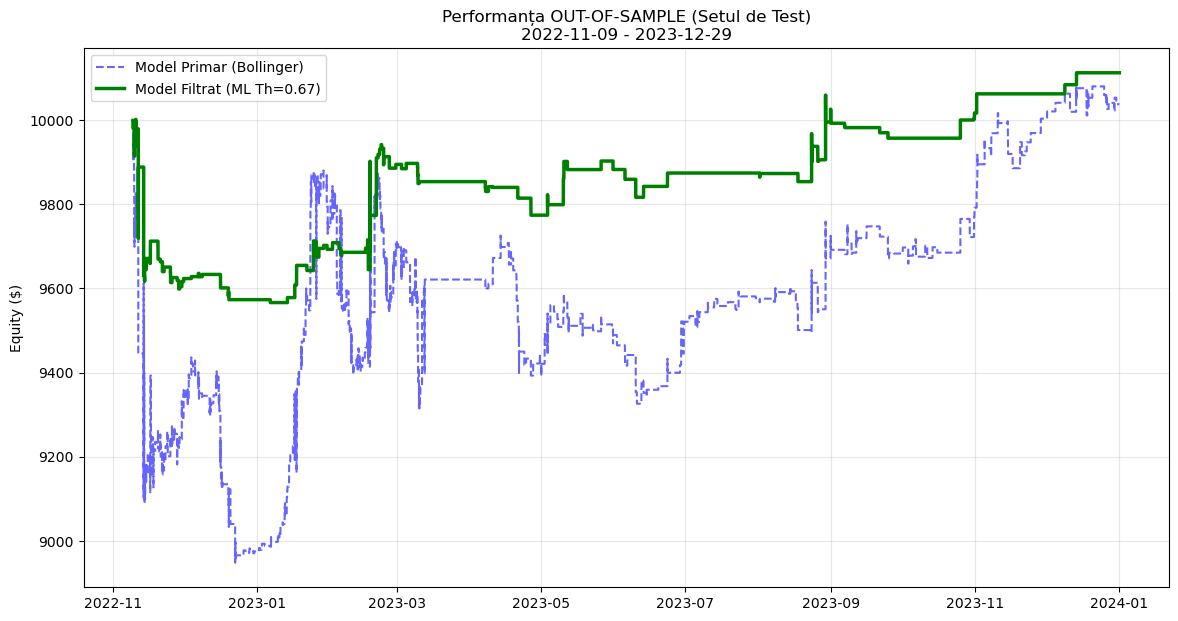

--- Buy & Hold (Benchmark) ---
Return:       133.32%
Max Drawdown: -22.27%
Tranzacții:   0
Win Rate:     0.00%

--- Strategie Primară ---
Return:       0.39%
Max Drawdown: -10.53%
Tranzacții:   947
Win Rate:     51.53%

--- Strategie Filtrată (ML) ---
Return:       1.13%
Max Drawdown: -4.36%
Tranzacții:   144
Win Rate:     52.08%



In [419]:
import matplotlib.pyplot as plt

# =========================================================
# 1. DEFINIRE PERIOADA DE TEST (OUT-OF-SAMPLE)
# =========================================================
test_start_date = test.index.min()
test_end_date = test.index.max()

print(f"Perioada de Testare: {test_start_date} -> {test_end_date}")

# Tăiem DataFrame-ul de prețuri doar pentru perioada de test
df_test = df.loc[test_start_date:].copy()

# Tăiem Volatilitatea pentru perioada de test
daily_vol_test = daily_vol.loc[test_start_date:]

# =========================================================
# 2. FILTRARE SEMNALE PENTRU TEST
# =========================================================

# A. Semnale PRIMARE (Bollinger) în perioada de test
signals_primary_test = events[events.index >= test_start_date].index

# B. Semnale FILTRATE (ML) în perioada de test
# Ne asigurăm că folosim threshold-ul optim (best_th) găsit anterior
events_test = events[events.index >= test_start_date].copy()
events_test['model_proba'] = rf.predict_proba(events_test[features])[:, 1]
signals_filtered_test = events_test[events_test['model_proba'] >= best_th].index

# =========================================================
# 3. RULARE BACKTEST STRICT PE TEST
# =========================================================
# Resetăm capitalul pentru a vedea clar evoluția de la 0
TEST_CAPITAL = 10000

# Backtest Model Primar (Neafiltrat)
eq_test_prim, stats_test_prim = backtest_primary_model(
    df=df_test,
    signals=signals_primary_test,
    volatility_series=daily_vol_test,
    pt_sl=pt_sl,
    barrier_days=5,
    fee=FEE,
    initial_capital=TEST_CAPITAL,
    investment_amount=1000
)

# Backtest Model Filtrat (ML)
eq_test_filt, stats_test_filt = backtest_primary_model(
    df=df_test,
    signals=signals_filtered_test,
    volatility_series=daily_vol_test,
    pt_sl=pt_sl,
    barrier_days=5,
    fee=FEE,
    initial_capital=TEST_CAPITAL,
    investment_amount=1000
)

# Buy & Hold (Calculat de la începutul perioadei de test)
bnh_shares_test = (TEST_CAPITAL * (1 - FEE)) / df_test['close'].iloc[0]
eq_test_bnh = df_test['close'] * bnh_shares_test

# =========================================================
# 4. PLOTARE
# =========================================================
plt.figure(figsize=(14, 7))

# Buy & Hold
# plt.plot(eq_test_bnh.index, eq_test_bnh.values, label='Buy & Hold', color='gray', alpha=0.4)

# Model Primar
plt.plot(eq_test_prim.index, eq_test_prim.values, label='Model Primar (Bollinger)', color='blue', linestyle='--', alpha=0.6)

# Model Filtrat
plt.plot(eq_test_filt.index, eq_test_filt.values, label=f'Model Filtrat (ML Th={best_th:.2f})', color='green', linewidth=2.5)

plt.title(f'Performanța OUT-OF-SAMPLE (Setul de Test)\n{test_start_date.date()} - {test_end_date.date()}')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 5. STATISTICI FINALE
# =========================================================
def print_test_stats(name, equity, trades):
    if equity.empty:
        print(f"--- {name} ---")
        print("Nicio tranzacție executată.")
        return

    ret = (equity.iloc[-1] - TEST_CAPITAL) / TEST_CAPITAL * 100
    dd = ((equity - equity.cummax()) / equity.cummax()).min() * 100
    n = len(trades)
    win_rate = (trades['pnl'] > 0).mean() * 100 if n > 0 else 0
    
    print(f"--- {name} ---")
    print(f"Return:       {ret:.2f}%")
    print(f"Max Drawdown: {dd:.2f}%")
    print(f"Tranzacții:   {n}")
    print(f"Win Rate:     {win_rate:.2f}%")
    print("")

print_test_stats("Buy & Hold (Benchmark)", eq_test_bnh, []) # Doar return relevant
print_test_stats("Strategie Primară", eq_test_prim, stats_test_prim)
print_test_stats("Strategie Filtrată (ML)", eq_test_filt, stats_test_filt)